In [14]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e12/sample_submission.csv
/kaggle/input/playground-series-s5e12/train.csv
/kaggle/input/playground-series-s5e12/test.csv


In [15]:
import pandas as pd


df = pd.read_csv('/kaggle/input/playground-series-s5e12/train.csv')

df.describe().T
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700000 entries, 0 to 699999
Data columns (total 26 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   id                                  700000 non-null  int64  
 1   age                                 700000 non-null  int64  
 2   alcohol_consumption_per_week        700000 non-null  int64  
 3   physical_activity_minutes_per_week  700000 non-null  int64  
 4   diet_score                          700000 non-null  float64
 5   sleep_hours_per_day                 700000 non-null  float64
 6   screen_time_hours_per_day           700000 non-null  float64
 7   bmi                                 700000 non-null  float64
 8   waist_to_hip_ratio                  700000 non-null  float64
 9   systolic_bp                         700000 non-null  int64  
 10  diastolic_bp                        700000 non-null  int64  
 11  heart_rate                

<Axes: xlabel='diagnosed_diabetes', ylabel='count'>

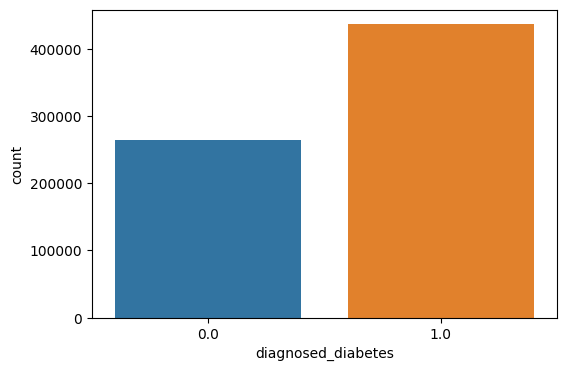

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt


df.describe().T

plt.figure(figsize=(6,4))

sns.countplot(x = 'diagnosed_diabetes',data=df)





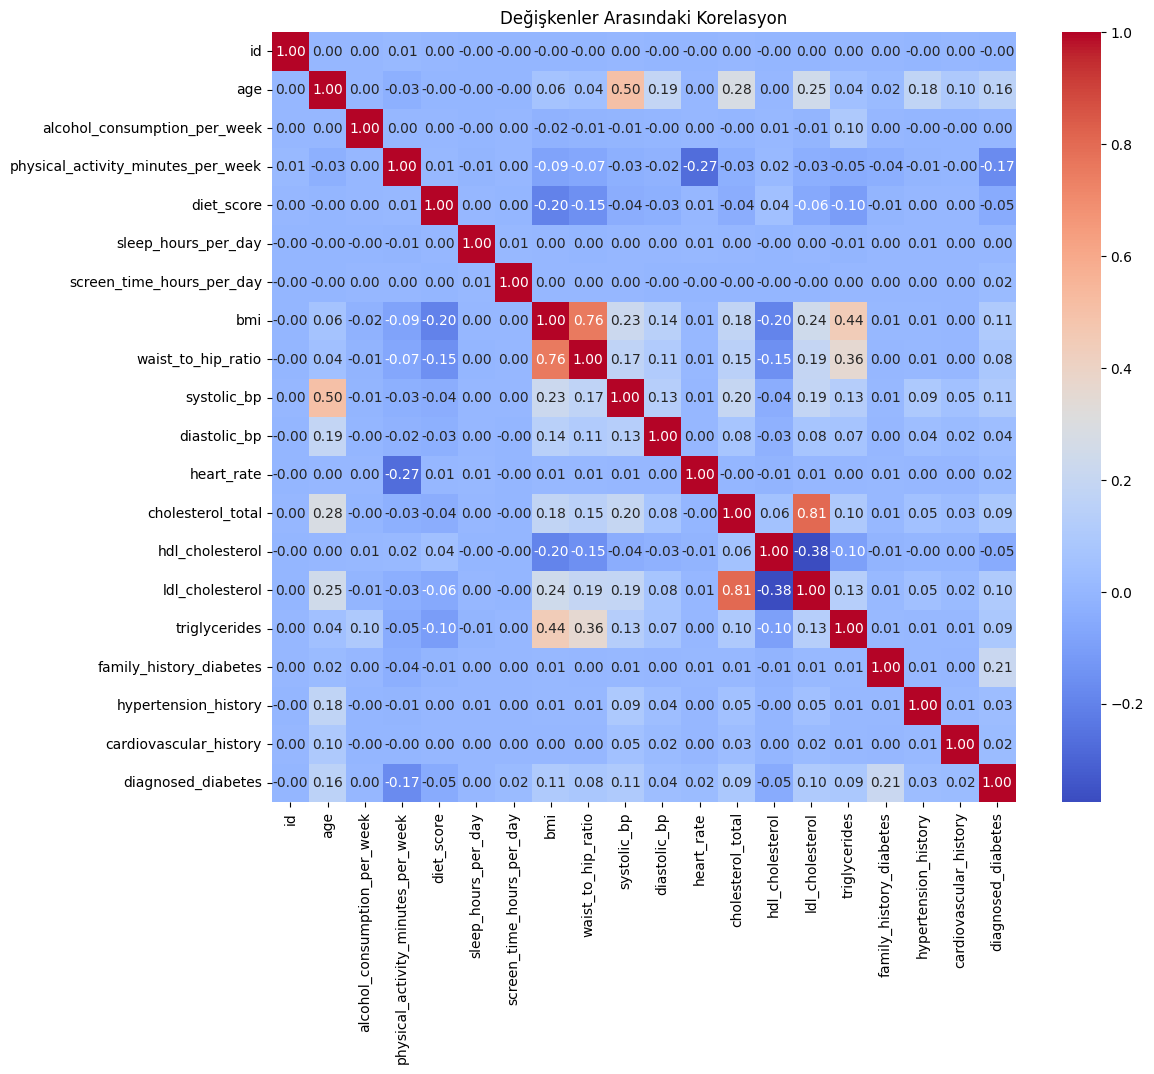

In [17]:
df_numbers = df.select_dtypes(['int64','float64'])


plt.figure(figsize=(12, 10))
# Sadece sayısal sütunları aldığımızdan emin olalım (bazı sürümlerde hata vermemesi için)
sns.heatmap(df_numbers.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Değişkenler Arasındaki Korelasyon")
plt.show()

## Correlations btw diabetes and biomarkers:


* **Age**: Naturally as age goes up chance of having diabetes is increasing.

* **Physical Activity**: Less physical activity ends in less muscle mass which is critical for avoiding diabetes.

* **Family History**: More diabetes in the family history seems to be increasing the chance of getting diabetes.

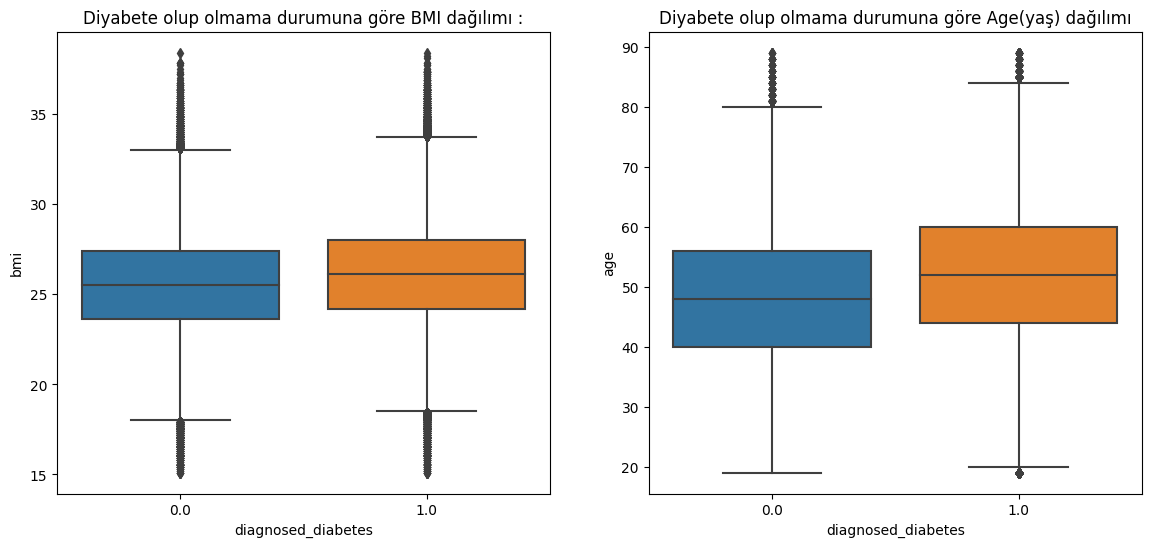

In [18]:
fig, axes = plt.subplots(1, 2, figsize = (14,6))

sns.boxplot(x = 'diagnosed_diabetes', y = 'bmi', data=df, ax=axes[0])

axes[0].set_title('Diyabete olup olmama durumuna göre BMI dağılımı :')

sns.boxplot(x = 'diagnosed_diabetes', y='age', data=df, ax=axes[1])

axes[1].set_title('Diyabete olup olmama durumuna göre Age(yaş) dağılımı')  

plt.show()

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# 1. ADIM: Gereksiz (birbiriyle aynı) sütunları atıyoruz
# 'diagnosed_diabetes' hedefimiz olduğu için onu zaten X'ten çıkarıyoruz.

features_to_drop = ['diagnosed_diabetes', 'cholesterol_total', 'waist_to_hip_ratio']


X = df.drop(features_to_drop, axis = 1)

y = df['diagnosed_diabetes']



X = pd.get_dummies(X, drop_first = True)
# 2. ADIM: train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)


#Burada logistic regression kullancaz 
#Max_iter = 1000 yapıyoruz ki modelin öğrenmesi için yeterince süre olsun


model = LogisticRegression(max_iter = 1000)
model.fit(X_train, y_train)

#4. Adımda test edicez şimdi
y_pred = model.predict(X_test)


#Sonuç:

print('Model Doğruluk Oranı: ', accuracy_score(y_test,y_pred))

print('\nDetaylı Rapor:\n', classification_report(y_test,y_pred))









Model Doğruluk Oranı:  0.6414642857142857

Detaylı Rapor:
               precision    recall  f1-score   support

         0.0       0.61      0.13      0.21     52629
         1.0       0.64      0.95      0.77     87371

    accuracy                           0.64    140000
   macro avg       0.63      0.54      0.49    140000
weighted avg       0.63      0.64      0.56    140000



## Neden:

* **Scaling çok uçuk**: Sayılar çok alakasız rangelerde kolestrol 100-300 arasıyken yaş 0-100 arasında BMI 20-40 arasında

In [20]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()

X_train_scaled  = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)


model_v2 = LogisticRegression(max_iter = 1000)

model_v2.fit(X_train_scaled, y_train)



y_pred_v2 = model_v2.predict(X_test_scaled)

print('Eski başarı oranı scalesız: %66.15')

print(f'Yeni başarı oranı scaling ile : %{accuracy_score(y_test,y_pred_v2)* 100:.2f}')




Eski başarı oranı scalesız: %66.15
Yeni başarı oranı scaling ile : %66.16


## Sonuç : 
* **Model sonucu**: Veri setimiz pek lineer değil
* **Örnek olarak**:
  * Sadece yaşı büyük olan hasta olmayabilir
  * Ama yaşı büyük ve BMI yüksek bir de ailesinde geçmişte bu hastalık var ise hasta olabilir o yüzden düz bir çizgi ile karar vermesi zor


* **Model seçimi**: Tree-Based Model büyük ihtimal iyi çalışacaktır
    * Değişkenlerin birbiri ile olan etkileşimleri daha iyi yakalayacak
    * Sınırları non-linear datasete daha uyumlu

In [21]:
from sklearn.ensemble import RandomForestClassifier


rf_model = RandomForestClassifier(n_estimators = 100, random_state=42)

print('Random Forest Eğitiliyor...')
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

print('-'* 30)

print(f'Random Forest Başarı Oranı : %{accuracy_score(y_test, y_pred_rf)}* 100:.2f')



print(classification_report(y_test, y_pred_rf))




Random Forest Eğitiliyor...
------------------------------
Random Forest Başarı Oranı : %0.66095* 100:.2f
              precision    recall  f1-score   support

         0.0       0.58      0.36      0.45     52629
         1.0       0.69      0.84      0.76     87371

    accuracy                           0.66    140000
   macro avg       0.63      0.60      0.60    140000
weighted avg       0.65      0.66      0.64    140000



## Rapor:

* **Random Forest**: Model beklediğim accuracye ulaşmadı
* **Yeni Model**: XGboost yapcaz artık çünkü ağır silahların zamanı geldi gibi

In [22]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators = 100,
    learning_rate = 0.1,
    max_depth = 5,
    random_state = 42,
    use_label_encoder = False,
    eval_metric = 'logloss'
)



print('XGBoost eğitiliyor...')

xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

print('--'*30)
print(f'XGBoost Başarı Oranı: %{accuracy_score(y_test, y_pred_xgb)* 100:.2f}')

print(classification_report(y_test,y_pred_xgb))




XGBoost eğitiliyor...
------------------------------------------------------------
XGBoost Başarı Oranı: %67.66
              precision    recall  f1-score   support

         0.0       0.61      0.38      0.47     52629
         1.0       0.70      0.86      0.77     87371

    accuracy                           0.68    140000
   macro avg       0.65      0.62      0.62    140000
weighted avg       0.66      0.68      0.65    140000



## Sabah ilk iş
* Şu hasta olmayanları tahminde neden zorlanıyor onu araştır
* Ve xgboost gibi güçlü bi model bile nasıl $%68$ accureacyde takıldı

------------------------------
LightGBM Eğitiliyor....
Training until validation scores don't improve for 50 rounds
[100]	valid_0's auc: 0.702793	valid_0's binary_logloss: 0.621374
[200]	valid_0's auc: 0.710156	valid_0's binary_logloss: 0.620142
[300]	valid_0's auc: 0.714792	valid_0's binary_logloss: 0.617393
[400]	valid_0's auc: 0.718025	valid_0's binary_logloss: 0.615056
[500]	valid_0's auc: 0.720405	valid_0's binary_logloss: 0.613264
[600]	valid_0's auc: 0.721504	valid_0's binary_logloss: 0.612381
[700]	valid_0's auc: 0.722537	valid_0's binary_logloss: 0.61155
[800]	valid_0's auc: 0.723253	valid_0's binary_logloss: 0.610954
[900]	valid_0's auc: 0.723638	valid_0's binary_logloss: 0.610615
[1000]	valid_0's auc: 0.724149	valid_0's binary_logloss: 0.610179
[1100]	valid_0's auc: 0.724597	valid_0's binary_logloss: 0.60978
[1200]	valid_0's auc: 0.724903	valid_0's binary_logloss: 0.609497
[1300]	valid_0's auc: 0.725115	valid_0's binary_logloss: 0.60928
[1400]	valid_0's auc: 0.725381	valid_0

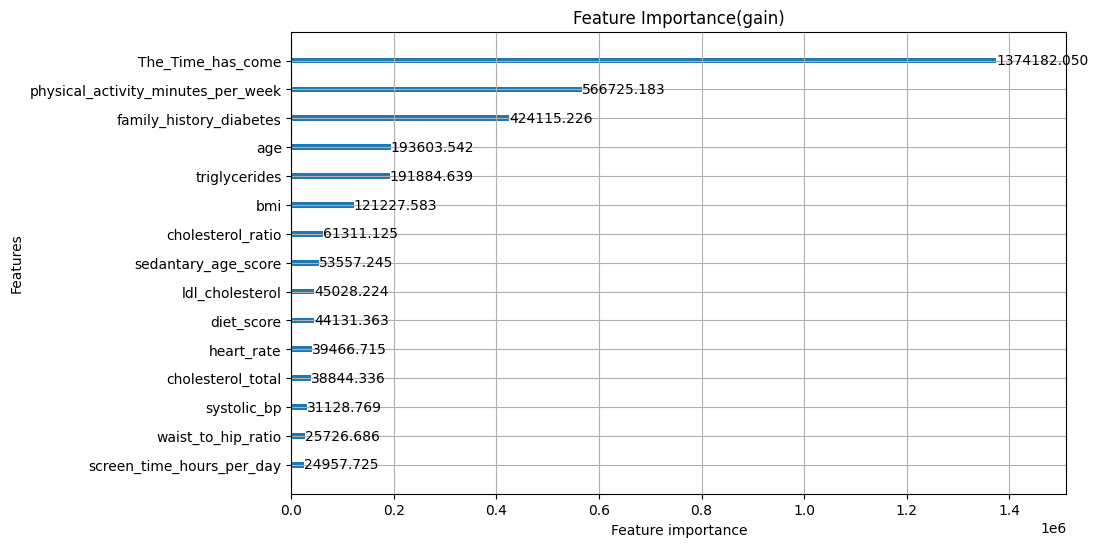

In [23]:
import lightgbm as lgb
from sklearn.metrics import confusion_matrix


#Feature Engineering yapacağız 

cat_cols = df.select_dtypes(include=['object']).columns

for col in cat_cols:
    df[col] = df[col].astype('category')

if  'id' in df.columns:
    df.drop('id', axis=1, inplace=True)





# Artık female male gibi object olan columnlar catergory oldu female = 0 male = 1 f harfi mden önce geldiği için



df['is_obese'] = (df['bmi']>30).astype(int)
df['cholesterol_ratio'] = df['ldl_cholesterol']/df['hdl_cholesterol']
df['sedantary_age_score'] = df['age'] / (df['physical_activity_minutes_per_week']+1)
df['BP_risk'] = df['systolic_bp'] > 140

df['The_Time_has_come'] = (df['age'] * (df['family_history_diabetes']+0.5))/(df['physical_activity_minutes_per_week']+1)
#Yukarıda ttanımladığım yeni featureler aile geçmişi ile birleştiğinde genelde diyabet kaçınılmazdır o yüzden onu 
# Bir nevim aktivasyon featureı olarak kullanacağım

sedantary_factor = 1000 / (df['physical_activity_minutes_per_week'] +1)
genetic_multiplier=df['family_history_diabetes']+0.5


df['Total_Metabolic_risk_score'] = df['systolic_bp'] * sedantary_factor * genetic_multiplier









X_lgbm = df.drop('diagnosed_diabetes', axis=1)
y_lgbm = df['diagnosed_diabetes']

X_lgbm_train, X_lgbm_test, y_lgbm_train, y_lgbm_test = train_test_split(X_lgbm,y_lgbm,test_size=0.2,random_state=42)


clf = lgb.LGBMClassifier(
    objective='binary', 
    is_unbalance=True, #Dengesiz veri setini otomatik yönetir
    n_estimators = 1500,
    learning_rate= 0.02, #Daha yavaş ve emin adımlarla ilerlesin diye
    num_leaves =30,
    max_depth=8,
    sub_sample=0.8,
    n_jobs=-1,
    verbose=-1
)


print('-'*30)
print('LightGBM Eğitiliyor....')

clf.fit(
    X_lgbm_train,y_lgbm_train,
    eval_set=[(X_lgbm_test,y_lgbm_test)],
    eval_metric='auc',
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(100)]
)

print('\n---Classification Report ---')

y_prob = clf.predict_proba(X_lgbm_test)[:,1]

y_pred = (y_prob >= 0.6).astype(int)
print(classification_report(y_lgbm_test,y_pred))

print('\n---Most important features ---')
lgb.plot_importance(clf, max_num_features = 15, importance_type='gain', title = 'Feature Importance(gain)',figsize=(10,6))


plt.show()


Özellikler üretiliyor...
🚀 LightGBM, ID olmadan TEMİZ halle yeniden eğitiliyor...
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1500]	valid_0's auc: 0.72531	valid_0's binary_logloss: 0.609817

Submission dosyası hazırlanıyor...
✅ Dosya hazır: submission_clean.csv (Yüklemeye hazır!)


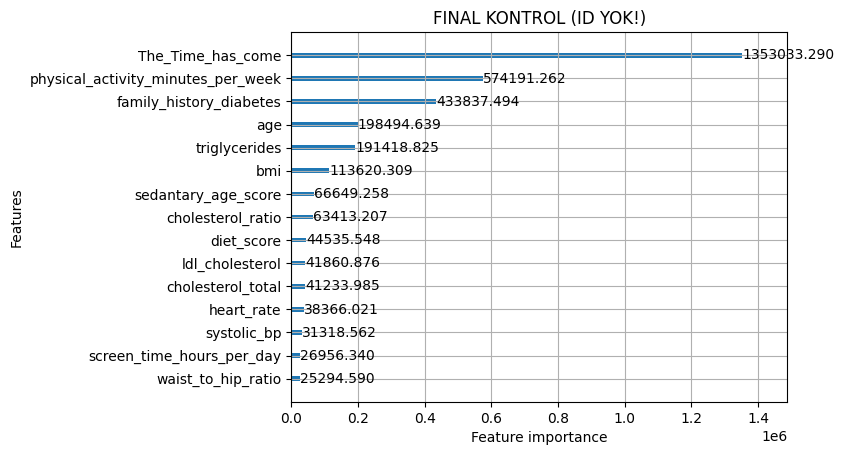

In [24]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# --- 1. VERİLERİ YÜKLE ---
df = pd.read_csv('/kaggle/input/playground-series-s5e12/train.csv') # Dosya adını gerekirse düzenle
test_df = pd.read_csv('/kaggle/input/playground-series-s5e12/test.csv')

# --- 2. ID SÜTUNLARINI GARANTİ SİL VE SAKLA ---
if 'id' in df.columns:
    df.drop('id', axis=1, inplace=True)

submission_ids = test_df['id'].copy() # Test ID'lerini sakla
if 'id' in test_df.columns:
    test_df.drop('id', axis=1, inplace=True)

# --- 3. FEATURE ENGINEERING (EĞİTİM VE TESTE AYNI ANDA UYGULA) ---
# Fonksiyon ile yapalım ki hata şansı kalmasın
def feature_engineer(data):
    # Kategori Dönüşümü
    cat_cols = data.select_dtypes(include=['object']).columns
    for col in cat_cols:
        data[col] = data[col].astype('category')
    
    # Yeni Özellikler
    data['is_obese'] = (data['bmi'] > 30).astype(int)
    data['cholesterol_ratio'] = data['ldl_cholesterol'] / data['hdl_cholesterol']
    # 'sedantary' yazım hatanı korudum :)
    data['sedantary_age_score'] = data['age'] / (data['physical_activity_minutes_per_week'] + 1)
    data['BP_risk'] = data['systolic_bp'] > 140
    
    # Golden Feature: The Time Has Come
    data['The_Time_has_come'] = (data['age'] * (data['family_history_diabetes'] + 0.5)) / (data['physical_activity_minutes_per_week'] + 1)
    
    # Total Metabolic Risk Score
    sedantary_factor = 1000 / (data['physical_activity_minutes_per_week'] + 1)
    genetic_multiplier = data['family_history_diabetes'] + 0.5
    data['Total_Metabolic_risk_score'] = data['systolic_bp'] * sedantary_factor * genetic_multiplier
    
    return data

print("Özellikler üretiliyor...")
df = feature_engineer(df)
test_df = feature_engineer(test_df)

# --- 4. MODELİ YENİDEN EĞİT (ID OLMADAN) ---
X = df.drop('diagnosed_diabetes', axis=1)
y = df['diagnosed_diabetes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

clf = lgb.LGBMClassifier(
    objective='binary',
    is_unbalance=True,
    n_estimators=1500,
    learning_rate=0.02,
    num_leaves=30,
    n_jobs=-1,
    verbose=-1
)

print("🚀 LightGBM, ID olmadan TEMİZ halle yeniden eğitiliyor...")
clf.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='auc',
    callbacks=[lgb.early_stopping(stopping_rounds=50)]
)

# --- 5. TAHMİN VE KAYIT ---
print("\nSubmission dosyası hazırlanıyor...")
predictions = clf.predict_proba(test_df)[:, 1]

submission = pd.DataFrame({
    'id': submission_ids,
    'diagnosed_diabetes': predictions
})

submission.to_csv('submission_clean.csv', index=False)
print("✅ Dosya hazır: submission_clean.csv (Yüklemeye hazır!)")

#KONTROL: Grafikte ID var mı?
lgb.plot_importance(clf, max_num_features=15, importance_type='gain', title='FINAL KONTROL (ID YOK!)')
plt.show()